In [2]:
import duckdb

%load_ext sql
conn = duckdb.connect(database=":memory:", read_only=False)

%sql conn --alias duckdb
%sql INSTALL spatial;
%sql LOAD spatial;

Loading configurations from /Users/markus/code/llm_duck/pyproject.toml.

Settings changed:

Config,value
feedback,True
autopandas,True


Running query in 'duckdb'

Running query in 'duckdb'

,Success


In [3]:
%%sql
# This script creates tables for service requests and MODZCTA data from the City of New York.
# The service requests data is loaded from a Parquet file, and the MODZCTA data is loaded from a CSV file.


CREATE OR REPLACE TABLE service_requests_2024 AS
    SELECT *, ST_Point(longitude, latitude) as geo_point FROM './data/cityofnewyork/service_requests_2024.parquet';

CREATE OR REPLACE TABLE modzcta AS
    SELECT 
        MODZCTA,
        label,
        STRING_SPLIT(ZCTA, ', ') AS ZCTA,
        pop_est, 
        the_geom,
        ST_GeomFromText(the_geom) AS geom
    FROM './data/cityofnewyork/modzcta.parquet'


Running query in 'duckdb'

,Count
0,178


In [ ]:
%%sql
# This script creates a new table that combines service requests with MODZCTA data.
# The service requests are joined with the MODZCTA data based on the geographic point of the service request and based of the ZCTA.
# This will be useful for analyzing service requests in relation to the MODZCTA areas

COPY (
        SELECT 
                sr.*,
                m1.MODZCTA AS MODZCTA_1,
                m1.label AS label_1,
                m1.ZCTA AS ZCTA_1,
                m1.pop_est AS pop_est_1,
                m2.MODZCTA AS MODZCTA_2,
                m2.label AS label_2,
                m2.ZCTA AS ZCTA_2,
                m2.pop_est AS pop_est_2
        FROM service_requests_2024 sr
        LEFT JOIN modzcta m1
                ON ST_Within(sr.geo_point, m1.geom)
        LEFT JOIN modzcta m2 
                ON array_contains(m2.ZCTA, sr.incident_zip)
        LIMIT 3500000
) TO "./data/cityofnewyork/service_requests_2024_modzcta.parquet"
(FORMAT PARQUET, COMPRESSION SNAPPY);

Running query in 'duckdb'

,Count
0,3446563


In [12]:
%%sql

CREATE OR REPLACE TABLE service_requests_2024_modzcta AS 
    SELECT * 
    FROM "./data/cityofnewyork/service_requests_2024_modzcta.parquet"

Running query in 'duckdb'

,Count
0,3446563


# Assumptions About MODZCTA and Zip That May Not Be True

1. **One-to-One Mapping Between MODZCTA and Zip Codes**:
    - It is assumed that each MODZCTA corresponds to a unique set of zip codes. However, in reality, zip codes may overlap multiple MODZCTA areas, or a single MODZCTA may encompass multiple zip codes.

2. **Geometric Containment of Zip Codes Within MODZCTA**:
    - The assumption that all points within a zip code's boundary are contained within the corresponding MODZCTA boundary may not hold true. Zip code boundaries and MODZCTA boundaries are defined independently and may not align perfectly.

3. **Uniform Population Distribution Within MODZCTA**:
    - It is often assumed that the population is evenly distributed across a MODZCTA area. In practice, population density can vary significantly within the same MODZCTA.

4. **Static Boundaries**:
    - The assumption that MODZCTA and zip code boundaries remain constant over time may not be accurate. Boundaries can change due to administrative updates or urban development.

5. **Complete Data Availability**:
    - It is assumed that all service requests have valid longitude, latitude, and zip code information. However, missing or incorrect data can lead to inaccuracies in analysis.

6. **Spatial Accuracy of MODZCTA Geometry**:
    - The MODZCTA geometry data is assumed to be precise and accurate. In reality, the geometry may have simplifications or inaccuracies that affect spatial calculations.

7. **Zip Code as a Reliable Proxy for Location**:
    - Using zip codes as a proxy for precise locations assumes that all service requests within a zip code are spatially close. This may not be true for large or irregularly shaped zip code areas.

8. **No Overlapping MODZCTA Areas**:
    - It is assumed that MODZCTA areas do not overlap. However, there could be cases where boundaries intersect, leading to ambiguity in spatial joins.

9. **Service Requests Are Always Within MODZCTA**:
    - The assumption that all service requests fall within a MODZCTA boundary may not hold true, especially for locations near the edges of the city or in areas with incomplete MODZCTA coverage.

10. **Uniform Data Quality Across Sources**:
     - It is assumed that data from different sources (e.g., MODZCTA geometry, service requests) is of consistent quality and format. Variations in data quality can introduce errors in analysis.

In [36]:
%%sql
-- Check for duplicates in service_requests_2024_modzcta
SELECT 
    unique_key,
    COUNT(*) as match_count,
    STRING_AGG(DISTINCT MODZCTA_1, ', ') as modzctas
FROM service_requests_2024_modzcta
GROUP BY unique_key
HAVING COUNT(*) > 1
ORDER BY match_count DESC
LIMIT 5;

Running query in 'duckdb'

,unique_key,match_count,modzctas


In [40]:
%%sql

SELECT 
count_if(incident_zip IS NULL) / count(*) * 100 as missing_zip_percentage,
count_if(geo_point IS NULL) / count(*) * 100 as missing_geo_point_percentage,
count_if(MODZCTA_1 != MODZCTA_2) / count(*) * 100 as missmatch_percentage,
count_if(MODZCTA_1 IS NULL and MODZCTA_2 IS NOT NULL) / count(*) * 100 as missing_modzcta_1_percentage,
count_if(MODZCTA_2 IS NULL and MODZCTA_1 IS NOT NULL) / count(*) * 100 as missing_modzcta_2_percentage,
count_if(MODZCTA_2 IS NULL and MODZCTA_1 IS NULL) / count(*) * 100 as missing_all_modzcta_percentage
FROM service_requests_2024_modzcta;


Running query in 'duckdb'

,missing_zip_percentage,missing_geo_point_percentage,missmatch_percentage,missing_modzcta_1_percentage,missing_modzcta_2_percentage,missing_all_modzcta_percentage
0,0.995223,1.552155,3.374231,1.037062,0.935744,0.549098


If it's acceptable to have a error rate around a few percentage points in matching of MODZCTA to service requests we can just use the simpler ZCTA to incident_zip mapping instead of the more complex geometry matching.

In [29]:
%%sql
-- Check for overlaps between MODZCTA polygons

 SELECT 
    a.MODZCTA AS modzcta_a,
    b.MODZCTA AS modzcta_b,
    ST_Area(ST_Intersection(a.geom, b.geom)) AS intersection_area
FROM modzcta a, modzcta b
WHERE a.MODZCTA < b.MODZCTA 
    AND ST_Overlaps(a.geom, b.geom)
ORDER BY intersection_area DESC

Running query in 'duckdb'

,modzcta_a,modzcta_b,intersection_area
0,11369,11370,2.654072e-09
1,10306,99999,2.390592e-09
2,10467,10470,1.032203e-09
3,10025,10027,1.011663e-09
4,11216,11221,8.382825e-10
5,11693,11694,7.709317e-10
6,10456,10459,7.541158e-10
7,11210,11230,7.001994e-10
8,11432,11435,6.133498e-10
9,11207,11236,5.340508e-10


/var/folders/vf/5vg5yq5n3dqcvvqg52qk6t5c0000gn/T/ipykernel_44524/1929512884.py:64: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


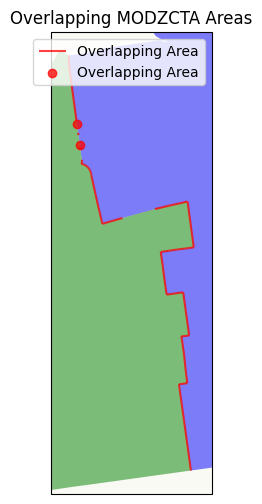

Overlapping area between MODZCTA 11369 and 11370: 24.90 square meters
Overlap percentage: 0.00026333%


In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads

# Fetch the first row of overlapping MODZCTA areas
overlap_row = conn.execute("""
    SELECT 
        a.MODZCTA AS modzcta_a,
        b.MODZCTA AS modzcta_b,
        a.the_geom AS geom_a,
        b.the_geom AS geom_b,
        ST_Area(ST_Intersection(a.geom, b.geom)) AS intersection_area
    FROM modzcta a, modzcta b
    WHERE a.MODZCTA != b.MODZCTA
        AND ST_Overlaps(a.geom, b.geom)
    ORDER BY intersection_area DESC
    LIMIT 1
""").fetchone()

if not overlap_row:
    print("No overlapping MODZCTA areas found.")
    raise ValueError("No overlapping MODZCTA areas found.")

modzcta_a, modzcta_b, geom_a, geom_b, area = overlap_row

# Convert WKT geometries to GeoDataFrames
shape_a = loads(geom_a)
shape_b = loads(geom_b)
gdf_a = gpd.GeoDataFrame(geometry=[shape_a])
gdf_b = gpd.GeoDataFrame(geometry=[shape_b])

# Plot the overlapping MODZCTA areas
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.3)

gdf_a.plot(ax=plt.gca(), color="blue", alpha=0.5, label=f"MODZCTA {modzcta_a}")
gdf_b.plot(ax=plt.gca(), color="green", alpha=0.5, label=f"MODZCTA {modzcta_b}")

# Calculate and plot the overlapping area
overlap_area = shape_a.intersection(shape_b)

modzcta_a_gdf_projected = gpd.GeoDataFrame(geometry=[shape_a], crs="EPSG:4326").to_crs(
    "EPSG:2263"
)
modzcta_b_gdf_projected = gpd.GeoDataFrame(geometry=[shape_b], crs="EPSG:4326").to_crs(
    "EPSG:2263"
)

overlap_gdf = gpd.GeoDataFrame(geometry=[overlap_area], crs="EPSG:4326")
overlap_gdf.plot(ax=plt.gca(), color="red", alpha=0.75, label="Overlapping Area")

# Zoom in on the overlapping area
ax.set_extent(
    [
        overlap_area.bounds[0] - 0.001,
        overlap_area.bounds[2] + 0.001,
        overlap_area.bounds[1] - 0.001,
        overlap_area.bounds[3] + 0.001,
    ],
    crs=ccrs.PlateCarree(),
)

plt.title("Overlapping MODZCTA Areas")
plt.legend()
plt.show()

# Calculate square meters of the overlapping area
overlap_gdf_projected = overlap_gdf.to_crs("EPSG:2263")  # NY State Plane
overlap_area_ft2 = overlap_gdf_projected.geometry.area[0]
overlap_area_m2 = overlap_area_ft2 * 0.092903  # Convert square feet to square meters

print(
    f"Overlapping area between MODZCTA {modzcta_a} and {modzcta_b}: {overlap_area_m2:.2f} square meters"
)

# Calculate area for the shapes
modzcta_a_area_m2 = modzcta_a_gdf_projected.geometry.area[0] * 0.092903
modzcta_b_area_m2 = modzcta_b_gdf_projected.geometry.area[0] * 0.092903

total_area_m2 = modzcta_a_area_m2 + modzcta_b_area_m2
overlap_percentage = (overlap_area_m2 / total_area_m2) * 100
print(f"Overlap percentage: {overlap_percentage:.8f}%")

Overlapping area between MODZCTA geom areas does not seem significant for the level of analysis we are doing. The geometry of the MODZCTA areas is not perfect but it is good enough for our purposes.

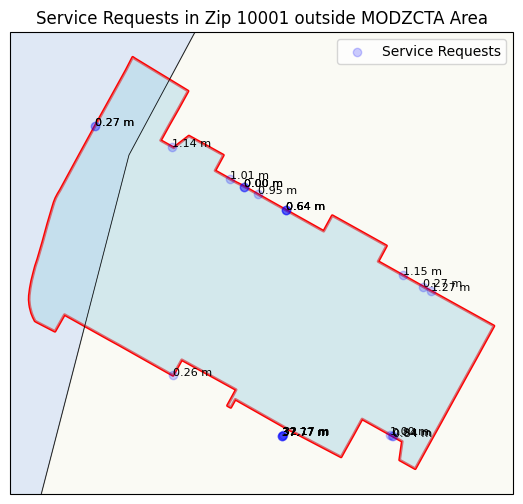

In [19]:
# The following code will plot the longitude and latitude of the service requests
# in a specific zip code and the corresponding MODZCTA area.
# It will also calculate the distance from the service request location to the MODZCTA area boundary,
# if the location is outside the MODZCTA area.

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.wkt import loads

df = conn.execute("""
    SELECT * FROM (
        SELECT 
            longitude,
            latitude,
            incident_zip
        FROM service_requests_2024_modzcta 
        WHERE incident_zip = '10001'
        -- Find service requests with coordinates outside the zip
        AND not array_contains(ZCTA_1, incident_zip)
    ) USING SAMPLE 25 ROWS
""").fetch_df()

plt.figure(figsize=(8, 6))

OFFSET = 0.001
ZIP = df["incident_zip"][0]

# Convert WKT geometry to a GeoDataFrame
modzcta_geom = conn.execute(
    """
    SELECT the_geom 
    FROM modzcta 
    WHERE array_contains(ZCTA, ?)
""",
    [ZIP],
).fetchone()

if not modzcta_geom:
    print("No MODZCTA geometry found for the given zip code.")
    raise ValueError("No MODZCTA geometry found.")

# Parse WKT geometry using shapely
modzcta_shape = loads(modzcta_geom[0])
modzcta_gdf = gpd.GeoDataFrame(geometry=[modzcta_shape], crs="EPSG:4326")

# Add map features using Cartopy scaled to the MODZCTA area
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(
    [
        modzcta_shape.bounds[0] - OFFSET,
        modzcta_shape.bounds[2] + OFFSET,
        modzcta_shape.bounds[1] - OFFSET,
        modzcta_shape.bounds[3] + OFFSET,
    ],
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.LAKES, edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.RIVERS, edgecolor="blue", alpha=0.3)

modzcta_gdf.plot(ax=plt.gca(), color="none", edgecolor="red", linewidth=2)
modzcta_gdf.plot(ax=plt.gca(), color="lightblue", alpha=0.5)

df["geometry"] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

# Create a GeoDataFrame from the DataFrame
df_gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")

# Convert the MODZCTA geometry and points to the same CRS for accurate distance calculations
modzcta_gdf_projected = modzcta_gdf.to_crs("EPSG:2263")  # NY State Plane

# Calculate distances for points outside the MODZCTA area
modzcta_shape_projected = modzcta_gdf_projected.geometry.iloc[0]
for _, row in df_gdf.iterrows():
    point_projected = row["geometry"]
    if not modzcta_shape_projected.contains(point_projected):
        distance_feet = point_projected.distance(modzcta_shape_projected.boundary)
        distance_meters = distance_feet * 0.3048  # Convert feet to meters
        if distance_meters > 0:
            plt.text(
                row["longitude"],
                row["latitude"],
                f"{distance_meters:.2f} m",
                fontsize=8,
                color="black",
            )

plt.scatter(
    df["longitude"],
    df["latitude"],
    c="blue",
    marker="o",
    label="Service Requests",
    alpha=0.2,
)
plt.title(f"Service Requests in Zip {ZIP} outside MODZCTA Area")

plt.legend()
plt.show()

Relying on the MODZCTA geometry to match service requests to MODZCTA areas is a more complex solution than using the ZCTA to incident_zip mapping. The latter is simpler and faster, but it may not be as accurate in some cases. The choice between the two methods depends on the specific requirements of the analysis and the acceptable level of error.

As seen in the above example, the assigned incident_zip codes are not always wihthin the MODZCTA area. For our purposes we are probably better off using the ZCTA to incident_zip mapping instead of the more complex geometry matching.